# Speech Processing: Exp 2


## Task 1

Write a program to speed up a speech file by a factor of $2$-to-$1$. Use the
method of overlap-add to analyze the STFT of the signal (using a rectangular window of length $512$ samples with $256$ sample overlap between frames), throw out every other frame, and re-synthesize the speeded-up speech. Plot the original speech file and the speeded up speech file, and plot the narrowband spectrograms of both the original and the speeded-up speech files. (Use the speech file `test_16k.wav` to test your program.)


### Solution


Waveform (Original)


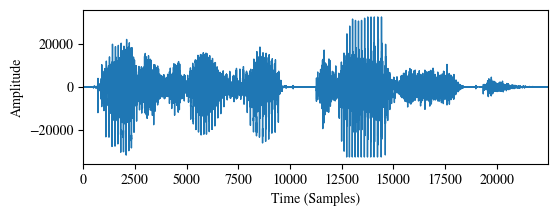

Spectrogram (Original)


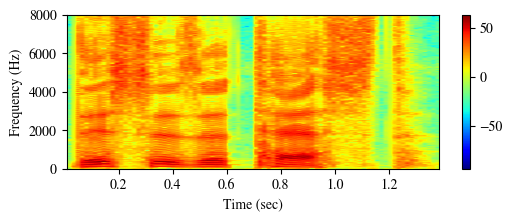

Waveform (Speeded-Up)


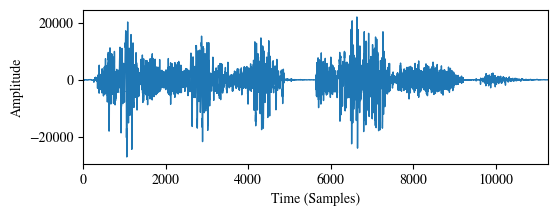

Spectrogram (Speeded-Up)


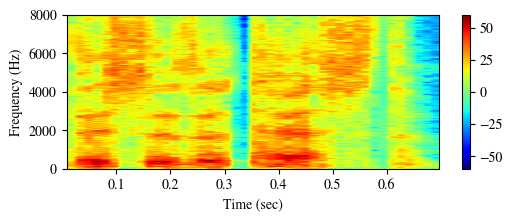

In [1]:
import numpy as np
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import matplotlib.pyplot as plt

rate, data = wavfile.read("test_16k.wav")
f, t, Zxx = signal.stft(data, rate, window="rect", nperseg=512, noverlap=256)
_, new_data = signal.istft(Zxx[:, ::2], rate, window="rect", nperseg=512, noverlap=256)
wavfile.write("test_16k_speeded_up.wav", rate, new_data.astype(np.int16))

print("Waveform (Original)")
plt.figure(figsize=(6, 2))
plt.plot(data)
plt.xlim(0, len(data))
plt.xlabel("Time (Samples)")
plt.ylabel("Amplitude")
plt.show()

print("Spectrogram (Original)")
plt.figure(figsize=(6, 2))
plt.specgram(data, NFFT=512, Fs=rate, noverlap=256, cmap="jet")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.colorbar()
plt.show()

print("Waveform (Speeded-Up)")
plt.figure(figsize=(6, 2))
plt.plot(new_data)
plt.xlim(0, len(new_data))
plt.xlabel("Time (Samples)")
plt.ylabel("Amplitude")
plt.show()

print("Spectrogram (Speeded-Up)")
plt.figure(figsize=(6, 2))
plt.specgram(new_data, NFFT=512, Fs=rate, noverlap=256, cmap="jet")
plt.xlabel("Time (sec)")
plt.ylabel("Frequency (Hz)")
plt.colorbar()
plt.show()

## Task 2

Write a program to compute the real cepstrum of a speech file and lifter the cepstrum using both a low quefrency lifter and a high quefrency lifter to illustrate the differences in retrieving a representation of the vocal tract response (the low quefrency lifter) or the source excitation (the high quefrency lifter). Use the speech file `test_16k.wav` with a voiced frame beginning at sample $13000$ (of duration $40\,\mathrm{msec}$) and an unvoiced frame beginning at sample $1000$ (again of duration $40\,\mathrm{msec}$). Use a Hamming window to isolate the frame of speech being processed. For both the voiced and unvoiced frames, plot the following quantities:

1. The Hamming window weighted speech section. (Make sure that you window length of $40\,\mathrm{msec}$ reflects the correct number of samples, based on the sampling rate of the speech signal.)
2. The log magnitude spectrum of the signal with the cepstrally smoothed log magnitude spectrum (in the case of a low quefrency lifter).
3. The real cepstrum of the speech signal.
4. The liftered log magnitude spectrum (for both low quefrency and high quefrency liftering operations).

Make plots for both voiced and unvoiced sections of speech, and for both the low and
high quefrency lifters. Your program should accept the following inputs:

- The speech file being processed.
- The starting sample for the speech frame being processed.
- The duration of the speech frame (in $\mathrm{msec}$) which must be converted to a frame duration in samples, based on the speech sampling rate.
- The size of FFT used in cepstral computation.
- The cutoff point of the cepstral lifter (either the high cutoff for a low quefrency lifter, or the low cutoff for a high quefrency lifter).
- The type of lifter (low quefrency or high quefrency).


### Solution


Weighted Frame (Voiced)


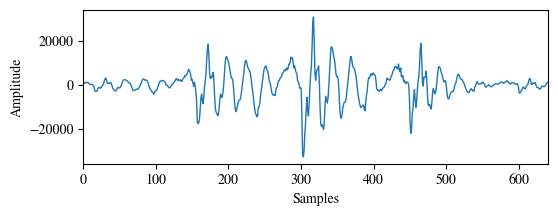

Real Cepstrum (Voiced)


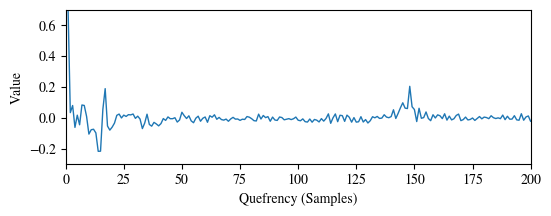

Log Magnitude Spectrum (Voiced)


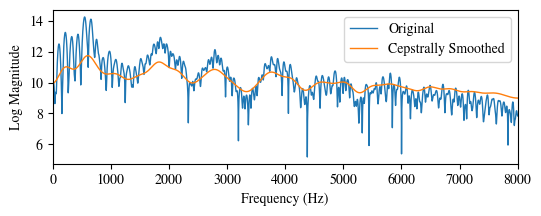

Liftered Log Magnitude Spectrum (Voiced, Low-Quefrency)


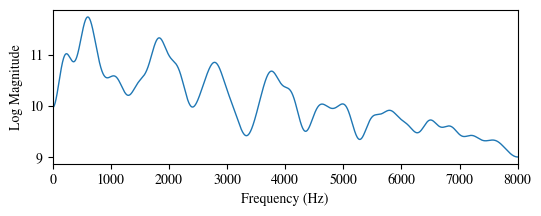

Liftered Log Magnitude Spectrum (Voiced, High-Quefrency)


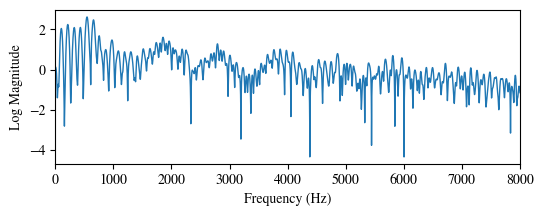

Weighted Frame (Unvoiced)


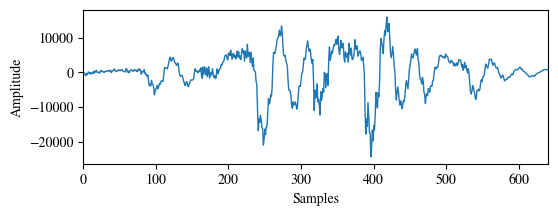

Real Cepstrum (Unvoiced)


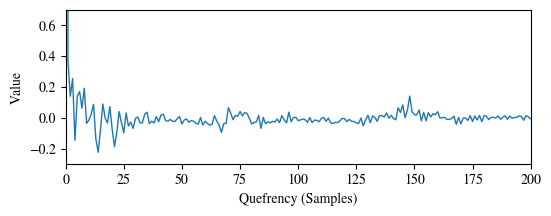

Log Magnitude Spectrum (Unvoiced)


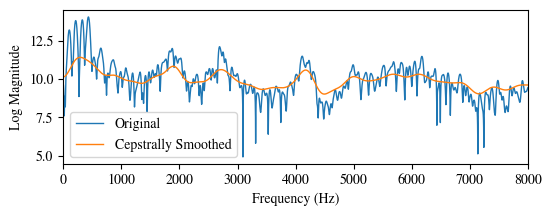

Liftered Log Magnitude Spectrum (Unvoiced, Low-Quefrency)


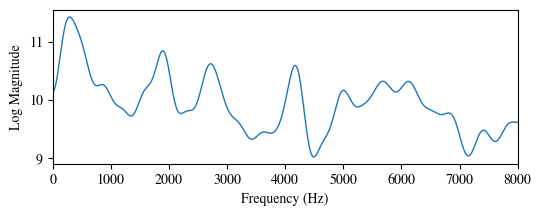

Liftered Log Magnitude Spectrum (Unvoiced, High-Quefrency)


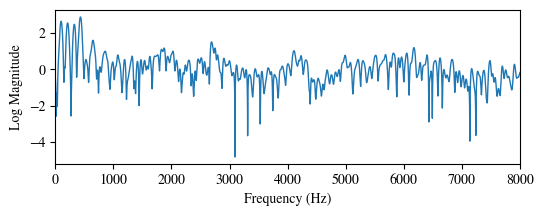

In [2]:
def main(
    file_path="test_16k.wav",
    first_sample=13000,
    duration=40,
    fft_size=16000,
    cutoff_quef=50,
    lifter_type="low",
    suffix=" (Voiced)",
    verbose=False,
):
    rate, data = wavfile.read(file_path)

    n_samples = int((duration / 1000) * rate)
    frame = data[first_sample : first_sample + n_samples]
    frame = frame * np.hamming(n_samples)

    spectrum = np.fft.fft(frame, fft_size)
    spectrum = np.log(np.abs(spectrum))
    cepstrum = np.fft.ifft(spectrum, fft_size).real

    lifter = np.ones(cepstrum.shape)
    if lifter_type == "low":
        lifter[cutoff_quef:] = 0
    elif lifter_type == "high":
        lifter[:cutoff_quef] = 0
    liftered_cepstrum = cepstrum * lifter
    liftered_spectrum = np.fft.fft(liftered_cepstrum, fft_size).real

    if verbose:
        print("Weighted Frame" + suffix)
        plt.figure(figsize=(6, 2))
        plt.plot(frame)
        plt.xlim(0, n_samples)
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.show()

        print("Real Cepstrum" + suffix)
        plt.figure(figsize=(6, 2))
        plt.plot(cepstrum)
        plt.xlim(0, 200)
        plt.ylim(-0.3, 0.7)
        plt.xlabel("Quefrency (Samples)")
        plt.ylabel("Value")
        plt.show()

        print("Log Magnitude Spectrum" + suffix)
        plt.figure(figsize=(6, 2))
        plt.plot(spectrum, label="Original")
        plt.plot(liftered_spectrum, label="Cepstrally Smoothed")
        plt.xlim(0, fft_size // 2)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Log Magnitude")
        plt.legend()
        plt.show()

    else:
        print("Liftered Log Magnitude Spectrum" + suffix)
        plt.figure(figsize=(6, 2))
        plt.plot(liftered_spectrum)
        plt.xlim(0, fft_size // 2)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Log Magnitude")
        plt.show()


main(first_sample=13000, suffix=" (Voiced)", verbose=True)
main(first_sample=13000, lifter_type="low", suffix=" (Voiced, Low-Quefrency)")
main(first_sample=13000, lifter_type="high", suffix=" (Voiced, High-Quefrency)")

main(first_sample=1000, suffix=" (Unvoiced)", verbose=True)
main(first_sample=1000, lifter_type="low", suffix=" (Unvoiced, Low-Quefrency)")
main(first_sample=1000, lifter_type="high", suffix=" (Unvoiced, High-Quefrency)")

Source excitation corresponds to high quefrency and is liftered out by low quefrency window; vocal tract response corresponds to low quefrency and is liftered out by high quefrency window.


## Task 3

Write a program to compute the optimal set of linear prediction coefficients from a frame of speech using the autocorrelation LPC analysis method. To test your program, use a frame of steady vowel and a frame of a fricative sound. Hence for each test example, you should input the following:

- Speech filename: `ah.wav` for the voiced test frame, `test_16k.wav` for the unvoiced test frame.
- Starting sample of frame: $3000$ for both the voiced and unvoiced test frames.
- Frame length (in samples): $300$ for the voiced frame (where the sampling frequency is $10\,\mathrm{kHz}$), $480$ for the unvoiced frame (where the sampling frequency is $16\,\mathrm{kHz}$).
- Window type: Hamming for both frames.
- LPC analysis order: $12$ for both the voiced and unvoiced frames.

For each of the analyzed frames, plot (on a single plot) the short-time Fourier transform log magnitude spectrum of the windowed frame of speech and the LPC log magnitude spectra from the autocorrelation LPC analysis method.


### Solution


ah.wav


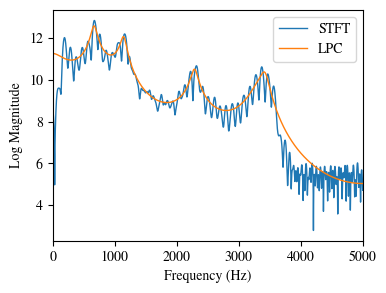

test_16k.wav


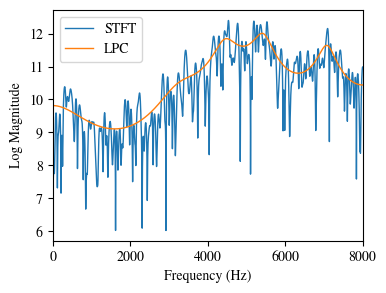

In [3]:
def main(
    file_path="test_16k.wav",
    first_sample=3000,
    n_samples=300,
    window_type="hamming",
    lpc_order=12,
):
    rate, data = wavfile.read(file_path)
    frame = data[first_sample : first_sample + n_samples]
    frame = frame * signal.get_window(window_type, n_samples)
    spectrum = np.fft.fft(frame, rate)
    spectrum = np.log(np.abs(spectrum))

    corr = np.zeros(lpc_order + 1)
    error = np.zeros(lpc_order + 1)
    coeff_prev = np.zeros(lpc_order + 1)
    coeff = np.zeros(lpc_order + 1)
    corr[0] = np.sum(frame**2)
    for i in range(1, lpc_order + 1):
        corr[i] = np.sum(frame[i:] * frame[:-i])
    # Levinson-Durbin Algorithm
    error[0] = corr[0]
    for i in range(1, lpc_order + 1):
        k = (corr[i] - np.sum(coeff_prev[1:i] * corr[i - 1 : 0 : -1])) / error[i - 1]
        coeff[i] = k
        for j in range(1, i):
            coeff[j] = coeff_prev[j] - k * coeff_prev[i - j]
        error[i] = (1 - k**2) * error[i - 1]
        coeff_prev[:] = coeff[:]
    coeff[0] = 1
    coeff[1:] *= -1
    gain = np.sqrt(np.sum(corr * coeff))
    lpc_spectrum = np.log(np.abs(gain / np.fft.fft(coeff, rate)))

    print(file_path)
    plt.figure(figsize=(4, 3))
    plt.plot(spectrum, label="STFT")
    plt.plot(lpc_spectrum, label="LPC")
    plt.xlim(0, rate // 2)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Log Magnitude")
    plt.legend()
    plt.show()


main("ah.wav", 3000, 300, "hamming", 12)
main("test_16k.wav", 3000, 480, "hamming", 12)

LP Analysis is seen to be a method of short-time spectrum estimation with removal of excitation fine structure (a form of wideband spectrum analysis)
